# **Algorithm and Data Mining for Data Science Homework 2**



## **#2 Homework: Instagram Profiles & Posts**

## **[RQ1] Data Analysis (EDA)**

In [3]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
posts = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  iterator=True, chunksize = 1000)

In [3]:
locations = pd.read_csv('../Datasets/instagram_locations.csv', sep='\t')
profiles = pd.read_csv('../Datasets/instagram_profiles.csv', sep='\t')

In [4]:
posts_chunk = posts.get_chunk(1000)

In [5]:
posts_chunk.head()

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
0,28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57.000,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
1,28370932,-1,BVg0pbolYBC,5579335020,457426771112991,2017-06-19 09:31:16.000,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
2,28370933,-1,BRgkjcXFp3Q,313429634,457426771112991,2017-03-11 20:05:03.000,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
3,28370934,-1,BKTKeNhjEA7,1837592700,457426771112991,2016-09-13 16:27:16.000,1,#teatime #scorpion #friends #love #mountains #...,4,0
4,28370935,-1,8-NQrvoYLX,1131527143,457426771112991,2015-10-18 10:19:27.000,1,thE sky gavE mE a #constEllation,8,0


In [6]:
posts_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sid              1000 non-null   int64 
 1   sid_profile      1000 non-null   int64 
 2   post_id          1000 non-null   object
 3   profile_id       1000 non-null   int64 
 4   location_id      1000 non-null   int64 
 5   cts              1000 non-null   object
 6   post_type        1000 non-null   int64 
 7   description      921 non-null    object
 8   numbr_likes      1000 non-null   int64 
 9   number_comments  1000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 78.2+ KB


In [7]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022658 entries, 0 to 1022657
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   sid                     1022658 non-null  int64  
 1   id                      1022658 non-null  int64  
 2   name                    1022658 non-null  object 
 3   street                  715704 non-null   object 
 4   zip                     715579 non-null   object 
 5   city                    937166 non-null   object 
 6   region                  1760 non-null     object 
 7   cd                      939010 non-null   object 
 8   phone                   601688 non-null   object 
 9   aj_exact_city_match     1000510 non-null  object 
 10  aj_exact_country_match  1000510 non-null  object 
 11  blurb                   406705 non-null   object 
 12  dir_city_id             495698 non-null   object 
 13  dir_city_name           495698 non-null   object 
 14  di

In [8]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509586 entries, 0 to 4509585
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   sid                  int64  
 1   profile_id           float64
 2   profile_name         object 
 3   firstname_lastname   object 
 4   description          object 
 5   following            float64
 6   followers            float64
 7   n_posts              float64
 8   url                  object 
 9   cts                  object 
 10  is_business_account  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 378.5+ MB


In [9]:
num_post_ids, num_loc_cities, num_profiles_names = posts_chunk['post_id'].nunique(), locations['city'].nunique(), profiles['profile_name'].nunique()

print("Unique post IDs: {}".format(num_post_ids))
print("Unique location cities: {}".format(num_loc_cities))
print("Unique profile names: {}".format(num_profiles_names))

Unique post IDs: 1000
Unique location cities: 118541
Unique profile names: 4508180


## **[RQ2] Simple Insights**

In [10]:
# Plot the number of posts for each profile in descending order
profiles.groupby(["profile_id"], dropna=True)['n_posts'].sum()
profiles.sort_values(by='n_posts', ascending = False)

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
3990313,3661552,1.996648e+08,jasem33312,jasem33312,NaN,2.0,82049.0,183730.0,NaN,2019-06-30 19:14:19.780 -0400,False
2571453,3288809,8.563367e+09,koenigpic,Helperwait Studio,Веб сайты от идеи до запуска,4538.0,675.0,142428.0,vk.com/ru.helperwait,2019-05-07 00:14:06.799 -0400,True
4338921,3970193,1.273455e+09,rudyanto62,Rudyanto 王耀祝,NaN,164.0,1693.0,126340.0,NaN,2019-07-15 10:00:51.171 -0400,False
3942129,3621669,9.813508e+06,hometown_ni,AngelsCowboysLakers,All about live & let live. Peace & Harmony. La...,7488.0,1755.0,125220.0,NaN,2019-06-27 02:49:38.140 -0400,False
4219642,3851869,1.607309e+09,dwfitfiber_thailand,เห็นผลตั้งแต่เซ็ตแรกท้าลอง,✿รับตัวแทนรายได้ดีมาก\n🏧 KTB l SCB l KBANK | B...,7490.0,44951.0,117262.0,bit.ly/2GdIYJl,2019-07-13 02:10:07.317 -0400,True
...,...,...,...,...,...,...,...,...,...,...,...
4509575,4184448,2.438073e+08,not_omeed,أوميد,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:39:06.271 -0400,NaN
4509577,4184452,6.567796e+08,shak._n5,Shakil Hussain,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:39:23.911 -0400,NaN
4509582,4184469,1.340704e+07,jornvlaeminck,Jorn Vlaeminck,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:41.628 -0400,NaN
4509583,4184470,6.007354e+09,s_degol,Sanne Degol,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:42.983 -0400,NaN


In [11]:
# What posts have the highest number of "likes"?
posts_numbr_likes = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['numbr_likes'])

In [12]:
posts_numbr_likes.sort_values(by='numbr_likes', ascending=False).head(10)

,numbr_likes
19624085,8822952.0
19623988,5447066.0
19624082,5116398.0
19623986,4271466.0
39701024,4264745.0
6293907,3586546.0
19624086,3558599.0
19802016,3533326.0
30850564,3340297.0
39812576,3311246.0


In [13]:
# What posts have the most and the least number of comments?
posts_number_comments = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['number_comments'])

In [14]:
most_comments = posts_number_comments.sort_values(by='number_comments', ascending=False).head(10)
least_comments = posts_number_comments.sort_values(by=['number_comments'], ascending=True).head(10)
pd.concat([most_comments,least_comments], axis = 0)

,number_comments
41873060,488953.0
12164781,313997.0
33261751,257488.0
11149127,214365.0
9383817,189888.0
5427268,180635.0
25257169,173988.0
6220011,170836.0
31689573,166919.0
14257307,166198.0


In [15]:
# How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.
posts_location = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['location_id'])

In [16]:
no_location = posts_location['location_id'].isna().sum()
tagged_location = posts_location['location_id'].count()

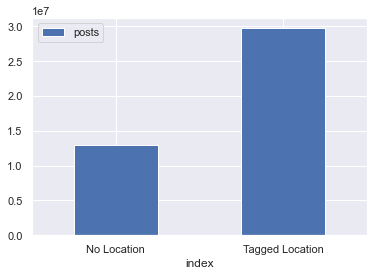

In [17]:
df = pd.DataFrame({'posts': [no_location, tagged_location],
                  'index': ['No Location', 'Tagged Location']})

plot = df.plot.bar(x='index', y='posts', rot=0)

Inserting a tag location results in greater visibility and increases the possibility of obtaining more followers

In [18]:
# How many posts include only photos? How many also have videos?
posts_post_type = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['post_type'])

In [19]:
only_photos = posts_post_type.loc[posts_post_type['post_type'] == 1, 'post_type'].sum()
video_multi = posts_post_type.loc[posts_post_type['post_type'] > 1, 'post_type'].sum()

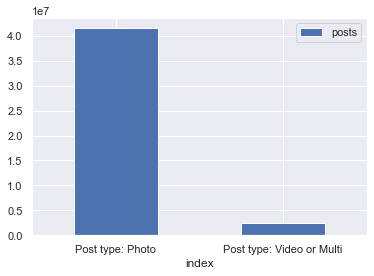

In [20]:
df = pd.DataFrame({'posts': [only_photos, video_multi],
                   'index': ['Post type: Photo', 'Post type: Video or Multi']})

plot = df.plot.bar(x='index', y='posts', rot=0)

In [21]:
# What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?
business, not_business = profiles['is_business_account'].value_counts()
not_business += profiles['is_business_account'].isnull().sum()
print("business account percentage: {}\nnot business account percentage: {}".format((business/profiles['is_business_account'].size) * 100 , (not_business/profiles['is_business_account'].size) * 100))

business account percentage: 57.43474012913824
not business account percentage: 42.56525987086176


from these percentages we can assure that instagram is used by many people as a source of profit rather than as social platform

## **[RQ3] Now it's important to understand the most common times in which users publish their posts**

In [22]:
# What is the most common time in which users publish their posts?
posts_cts = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['cts'])

In [23]:
profiles['times'] = pd.to_datetime(posts_cts['cts']).dt.strftime('%H:%M:%S')
cts = profiles.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)
cts

,times,number_posts_submitted
73747,20:29:07,119
70217,19:30:17,118
75606,21:00:06,112
72015,20:00:15,110
61215,17:00:15,110
...,...,...
23068,06:24:28,14
30328,08:25:28,14
27529,07:38:49,14
22352,06:12:32,12


In [24]:
# Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.
def plot_posts_per_time(interval_list, data):

    data['times'] = pd.to_datetime(data['times'], format='%H:%M:%S').dt.time
    times = list(zip(data.times, data.number_posts_submitted))
    default_value = 0
    keys = []
    for initial_time, end_time in interval_list:
        keys.append(initial_time + '-' + end_time)
    posts_in_intervals = dict.fromkeys(keys,default_value)
    for initial_time, end_time in interval_list:
        for time, num_post in times:
            if pd.to_datetime(initial_time).time() <= time <= pd.to_datetime(end_time).time():
                posts_in_intervals[initial_time + '-' + end_time] += num_post

    fig, ax = plt.subplots()
    ax.barh(*zip(*posts_in_intervals.items()))
    plt.show()

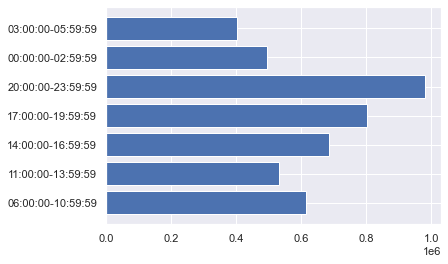

In [25]:
# Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

interval_list = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'), ('14:00:00', '16:59:59'), ('17:00:00', '19:59:59'), ('20:00:00', '23:59:59'), ('00:00:00', '02:59:59'), ('03:00:00','05:59:59')]

plot_posts_per_time(interval_list, cts)

## **[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.**

In [26]:
# Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.
posts_for_r4 = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['profile_id', 'numbr_likes', 'number_comments','cts','location_id', 'post_type'])

In [27]:
def get_posts_by_profile_id(profile_id):
    return posts_for_r4.query("profile_id == {}".format(profile_id))

get_posts_by_profile_id(260162660)

,profile_id,location_id,cts,post_type,numbr_likes,number_comments
980,260162660.0,5.275038e+14,2018-03-11 14:48:58.000,1,18.0,0.0
981,260162660.0,5.275038e+14,2019-05-24 09:04:47.000,1,1.0,0.0
982,260162660.0,5.275038e+14,2019-05-18 20:30:53.000,1,11.0,0.0
983,260162660.0,5.275038e+14,2019-05-18 02:05:56.000,1,14.0,2.0
984,260162660.0,5.275038e+14,2019-05-16 14:41:08.000,1,4.0,0.0
985,260162660.0,5.275038e+14,2019-05-16 04:09:50.000,1,4.0,0.0
986,260162660.0,5.275038e+14,2019-05-15 13:54:26.000,2,31.0,1.0
987,260162660.0,5.275038e+14,2019-05-04 01:45:16.000,1,10.0,0.0
988,260162660.0,5.275038e+14,2019-04-30 05:56:05.000,2,0.0,0.0
989,260162660.0,5.275038e+14,2019-03-29 01:34:28.000,1,11.0,2.0


In [28]:
# Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

def post_of_n_top_posted_profiles(n):
    profiles.groupby(["profile_id"], dropna=True)['n_posts'].sum()
    n_top_profiles = profiles.sort_values(by='n_posts', ascending = False).head(n)
    filter_list = n_top_profiles['profile_id']
    return posts_for_r4[posts_for_r4['profile_id'].isin(filter_list)]

In [29]:
# What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?
posts_of_n_top_profiles = post_of_n_top_posted_profiles(10)
print("Average number of likes: {}\nAverage number of comments: {}".format(posts_of_n_top_profiles['numbr_likes'].mean(), posts_of_n_top_profiles['number_comments'].mean()))

Average number of likes: 3.1713483146067416
Average number of comments: 0.033707865168539325


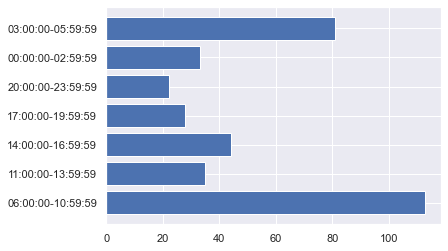

In [30]:
# Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.
posts_of_n_top_profiles = post_of_n_top_posted_profiles(10)
import warnings
warnings.simplefilter('ignore',lineno=5)
posts_of_n_top_profiles['times'] = pd.to_datetime(posts_of_n_top_profiles['cts']).dt.strftime('%H:%M:%S')
posts_of_top_profiles = posts_of_n_top_profiles.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)

plot_posts_per_time(interval_list, posts_of_top_profiles)

## **[RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.**

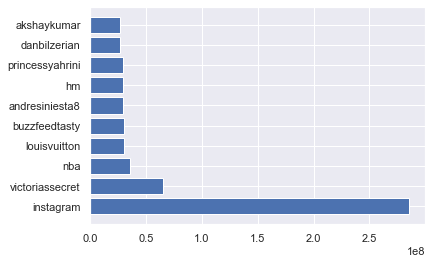

In [31]:
# Plot the top 10 most popular users in terms of followers and their number of posts.
top_ten_most_popular_profiles = profiles.sort_values(['followers'], ascending=False).head(10)
fig, ax = plt.subplots()
ax.barh(top_ten_most_popular_profiles['profile_name'], top_ten_most_popular_profiles['followers'])
plt.show()

In [32]:
# Who is the most influential user?
top_ten_most_popular_profiles.loc[top_ten_most_popular_profiles['followers'] == top_ten_most_popular_profiles['followers'].max()]

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account,times
2880218,336492,25025320.0,instagram,Instagram,Bringing you closer to the people and things y...,226.0,285457645.0,5760.0,help.instagram.com,NaN,False,00:05:49


In [33]:
def post_of_n_top_following_profiles(n):
    profiles.groupby(["profile_id"], dropna=True)['n_posts'].sum()
    n_top_profiles = profiles.sort_values(by='followers', ascending = False).head(n)
    filter_list = n_top_profiles['profile_id']
    return posts_for_r4[posts_for_r4['profile_id'].isin(filter_list)]

In [34]:
# Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.
posts_of_n_top_profiles = post_of_n_top_following_profiles(10)
posts_of_top_profiles = posts_of_n_top_profiles[posts_of_n_top_profiles['profile_id'].isin(top_ten_most_popular_profiles['profile_id'])]
locations_count = posts_of_top_profiles.groupby(['location_id'])['location_id'].count().reset_index(name='location_count')
most_frequent_areas = locations.loc[locations['id'].isin(locations_count['location_id'])][['id','city']].rename(columns = {'id':'location_id'})
most_frequent_areas.dropna(inplace=True)

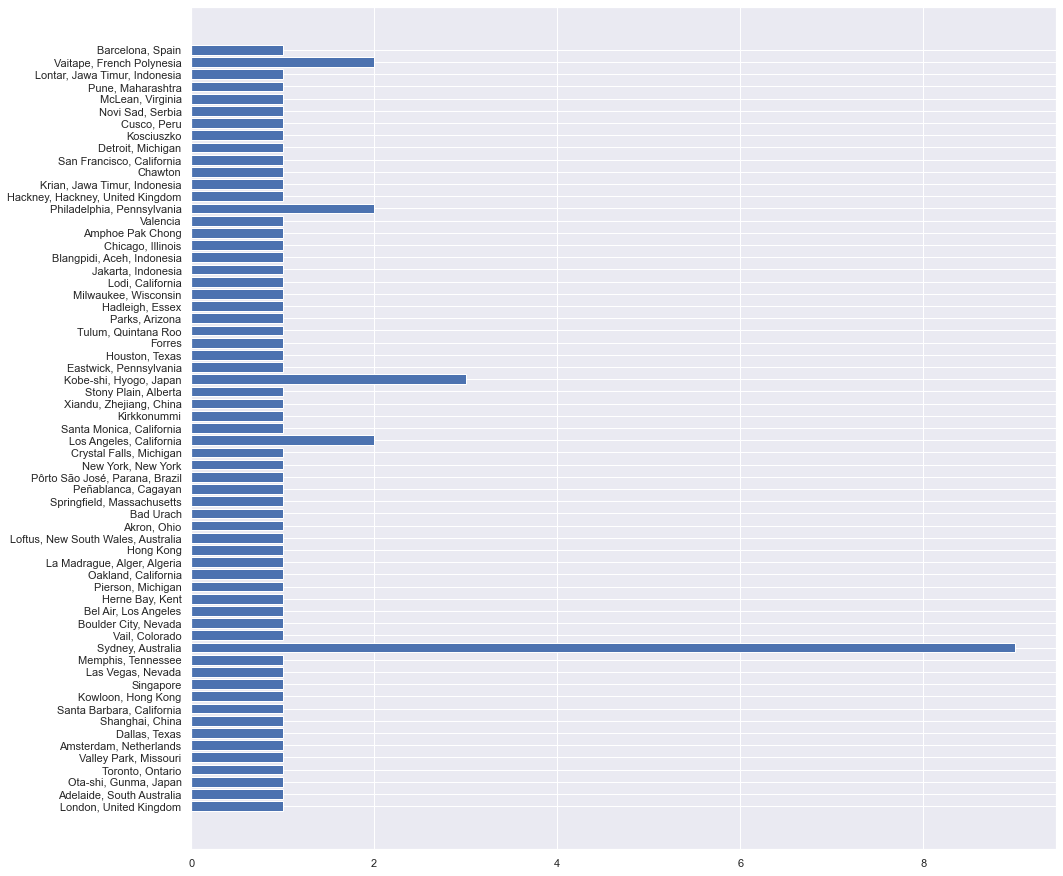

In [35]:
cities_counts = pd.merge(locations_count, most_frequent_areas, on="location_id").astype({'location_id': int, 'city': str, 'location_count': int})
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 15.5)
ax.barh(cities_counts.city, cities_counts.location_count)
plt.show()

In [36]:
# How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.
top_profile_only_photo_posts = posts_of_top_profiles[posts_of_top_profiles.post_type == 1]
top_profile_reels_posts = posts_of_top_profiles[posts_of_top_profiles.post_type == 2]
top_profile_multi_posts = posts_of_top_profiles[posts_of_top_profiles.post_type == 3]

print("Percentage of photo posts: {}%".format(round(len(top_profile_only_photo_posts.index)/len(posts_of_top_profiles.index),3)*100))
print("Percentage of reels posts: {}%".format(round(len(top_profile_reels_posts.index)/len(posts_of_top_profiles.index),3)*100))
print("Percentage of multi posts: {}%".format(round(len(top_profile_multi_posts.index)/len(posts_of_top_profiles.index),3)*100))

Percentage of photo posts: 90.8%
Percentage of reels posts: 9.2%
Percentage of multi posts: 0.0%


In [37]:
# How many "likes" and comments did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

likes_photos = int(np.average(top_profile_only_photo_posts.numbr_likes))
comments_photos = int(np.average(top_profile_only_photo_posts.number_comments))

likes_reels = int(np.average(top_profile_reels_posts.numbr_likes))
comments_reels = int(np.average(top_profile_reels_posts.number_comments))

likes_multi = int(np.average(top_profile_multi_posts.numbr_likes if top_profile_multi_posts.size != 0 else 0))
comments_multi = int(np.average(top_profile_multi_posts.number_comments if top_profile_multi_posts.size != 0 else 0))

profile_followers = int(np.average(top_ten_most_popular_profiles.followers))

print("average likes and comments of photos posts: {} / {}".format(likes_photos,comments_photos))
print("average likes and comments of reels posts: {} / {}".format(likes_reels,comments_reels))
print("average likes and comments of multi posts: {} / {}".format(likes_multi,comments_multi))
print("average number of followers: {}".format(profile_followers))

average likes and comments of photos posts: 541294 / 3882
average likes and comments of reels posts: 266524 / 2019
average likes and comments of multi posts: 0 / 0
average number of followers: 58749283


most popular profiles generally post more photos than videos and they receive few number of likes and comments in comparison with their average number of followers

## **[RQ6] It's time to get information from the user posting effectiveness.**

In [38]:
# What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.
def time_intervals_between_posts():
    df = pd.DataFrame({'profile_id': posts_for_r4['profile_id'], 'cts': pd.to_datetime(posts_for_r4['cts']).dt.floor('T')})
    df = df.sort_values(by=["profile_id","cts"])
    df['cts_previous'] = df.groupby('profile_id')['cts'].shift()
    df['diff_from_previous'] = df['cts'] - df['cts_previous']
    df['diff_from_previous'] = df['diff_from_previous'].fillna(pd.Timedelta("0 days 00:00:00"))
    return df

In [39]:
df = time_intervals_between_posts()

In [40]:
df2 = pd.DataFrame({'profile_id': df['profile_id'], 'diff_from_previous': df['diff_from_previous']}).dropna()
df3 = df2.groupby('profile_id').mean(numeric_only = False)
three_most_frequent_uploading_user = df3[df3['diff_from_previous'] != pd.Timedelta("0 days 00:00:00")].sort_values('diff_from_previous').head(3)

In [41]:
three_most_frequent_uploading_user

,diff_from_previous
profile_id,
8.972807e+09,0 days 00:00:05
9.031308e+09,0 days 00:00:05
3.020706e+09,0 days 00:00:05


In [42]:
three_most_frequent_uploading_user = profiles[profiles['profile_id'].isin(three_most_frequent_uploading_user.index)]

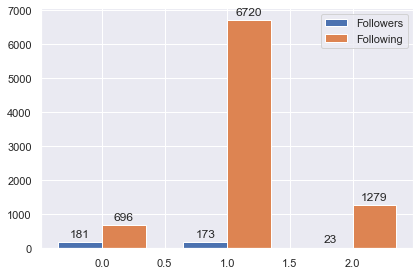

In [43]:
labels = three_most_frequent_uploading_user['profile_name']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, three_most_frequent_uploading_user['followers'], width, label='Followers')
rects2 = ax.bar(x + width/2, three_most_frequent_uploading_user['following'], width, label='Following')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

From the chart we can see that all three profiles have common features. All three have few number of followers and large number of following.

In [44]:
# Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.


## **[RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let’s compute some engaging figures**

In [48]:
#What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

#extract only columns of interest
profiles_filtered = profiles[["profile_id", "followers"]]
profiles_filtered

,profile_id,followers
0,4.721050e+09,146.0
1,5.905830e+08,1145.0
2,1.074147e+09,324.0
3,1.472039e+09,NaN
4,3.531421e+09,NaN
...,...,...
4509581,1.418322e+09,481.0
4509582,1.340704e+07,NaN
4509583,6.007354e+09,NaN
4509584,2.338990e+07,153.0


In [49]:
posts_filtered = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=["profile_id", "numbr_likes"])

#join the two sub_datasets
merged = pd.merge(profiles_filtered.dropna(), posts_filtered.dropna(), on='profile_id')

#remove Nan (we can drop this step when running the code on the entire dataset
merged_without_NaN = merged.dropna(subset = ["followers","numbr_likes"])

In [53]:
#this function returns 1 if the post received more likes than the 20% of total followers, 0 otherwise
def popular_post (row):
    if row['followers']*0.2 < row["numbr_likes"]:
        return 1
    return 0

#append new column with 1s or 0s
merged_without_NaN['popular_post'] = merged_without_NaN.apply (lambda row: popular_post(row), axis=1)
merged_without_NaN

,profile_id,followers,numbr_likes,popular_post
0,4.721050e+09,146.0,5.0,0
1,4.721050e+09,146.0,9.0,0
2,4.721050e+09,146.0,14.0,0
3,4.721050e+09,146.0,14.0,0
4,4.721050e+09,146.0,17.0,0
...,...,...,...,...
24708639,2.338990e+07,153.0,16.0,0
24708640,2.338990e+07,153.0,14.0,0
24708641,2.338990e+07,153.0,30.0,0
24708642,2.338990e+07,153.0,0.0,0


In [54]:
#get mean of "popular_post" column as a probability
p_of_popular_post = merged_without_NaN["popular_post"].mean()
p_of_popular_post

0.15716325833178058

In [55]:
#Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

posts_unique = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=["profile_id", "location_id"])
posts_unique1 = posts_unique.drop_duplicates(keep='first')
posts_unique1

,profile_id,location_id
0,2.237948e+09,1.022366e+15
1,5.579335e+09,4.574268e+14
2,3.134296e+08,4.574268e+14
3,1.837593e+09,4.574268e+14
4,1.131527e+09,4.574268e+14
...,...,...
42710192,5.556457e+09,4.574268e+14
42710193,3.371865e+08,4.574268e+14
42710194,3.289886e+09,4.574268e+14
42710195,8.536366e+09,4.267235e+06


In [56]:
p_of_back_to_location = (len(posts_unique) - len(posts_unique1))/len(posts_unique)
p_of_back_to_location
#This result means that by picking a post in the posts dataset, it has around 20% probability to be a post whose location has already been visited by the user in the past.

0.46023983452944506

## **[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='numbr_likes', ylabel='number_comments'>

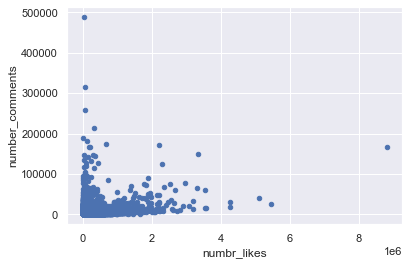

In [4]:
# Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts
posts_chunk = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t",  usecols=['numbr_likes', 'number_comments','cts'])
posts_chunk.plot.scatter(x='numbr_likes',y='number_comments')

In [61]:
# Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.
just_likes_comments_H = posts_chunk[["cts", "numbr_likes", "number_comments"]]
just_likes_comments_H['cts'] = pd.to_datetime(just_likes_comments_H['cts']).dt.strftime('%H')#:%S

#Here we create two sub-datasets. "mean_per_hour" will be used for linear regression and correlation, while "chi_square" will be used for the chi squared test.

#"mean_per_hour" will have as columns: cts (the different time ranges), "numbr_likes" (the mean for each time range) and "number_comments"(the mean for each time range)
mean_per_hour = just_likes_comments_H.groupby(['cts'], as_index = False)['numbr_likes',"number_comments"].mean().sort_values(['cts'], ascending=True)

sum_per_hour = just_likes_comments_H.groupby(['cts'], as_index = False)['numbr_likes',"number_comments"].sum().sort_values(['cts'], ascending=True)

just_likes_comments_H['cts'].astype(str)
just_likes_comments_H_countcts = just_likes_comments_H.value_counts(['cts']).reset_index(name='count_per_cts')

#"chi_square" will have as columns: cts (the different time ranges), "numbr_likes" (the sum for each time range), "number_comments"(the sum for each time range) and "count_per_cts" (number of posts per time range).
chi_square = pd.merge(sum_per_hour, just_likes_comments_H_countcts, how='left', on='cts')

<ipython-input-61-f7309c8d726e>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_per_hour = just_likes_comments_H.groupby(['cts'], as_index = False)['numbr_likes',"number_comments"].mean().sort_values(['cts'], ascending=True)
<ipython-input-61-f7309c8d726e>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sum_per_hour = just_likes_comments_H.groupby(['cts'], as_index = False)['numbr_likes',"number_comments"].sum().sort_values(['cts'], ascending=True)


<AxesSubplot:ylabel='cts_range'>

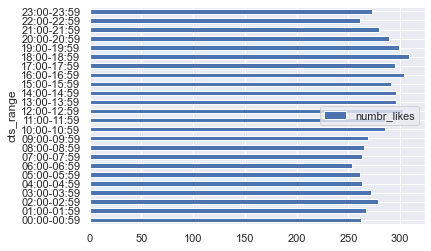

In [62]:
mean_per_hour['cts_range'] = mean_per_hour['cts'] +":00-"+mean_per_hour['cts']+':59'
mean_likes_per_hour = mean_per_hour[["cts_range", "numbr_likes"]]
mean_likes_per_hour.plot.barh(x="cts_range", y="numbr_likes")

In [63]:
mean_per_hour[["cts"]].astype(int)

,cts
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


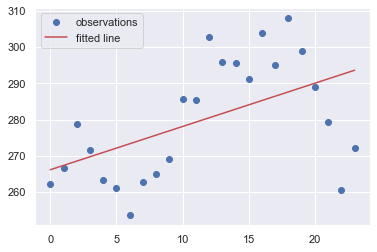

slope (95%): 1.193376 +/- 0.879745
intercept (95%): 266.186019 +/- 11.808479


In [64]:
#test 1: linear regression
#Regression model cts vs likes
import matplotlib.pyplot as plt
from scipy import stats
x = mean_per_hour["cts"].astype(int)
y = mean_per_hour["numbr_likes"]
res = stats.linregress(x, y)
plt.plot(x, y, 'o', label='observations')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
#slope (95%): 8.052236 +/- 11.406077
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
#intercept (95%): 215.933621 +/- 153.099415

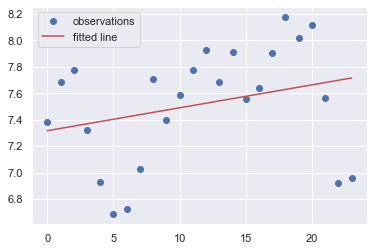

slope (95%): 0.017325 +/- 0.026338
intercept (95%): 7.316525 +/- 0.353526


In [65]:
#Regression model cts vs comments
x = mean_per_hour["cts"].astype(int)
y = mean_per_hour["number_comments"]
res = stats.linregress(x, y)
plt.plot(x, y, 'o', label='observations')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
#slope (95%): -0.340938 +/- 0.526385
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
#intercept (95%): 11.804804 +/- 7.065470

In [66]:
#test 2: Correlation
corr_cts_likes = mean_per_hour["cts"].astype(int).corr(mean_per_hour["numbr_likes"])
corr_cts_comments = mean_per_hour["cts"].astype(int).corr(mean_per_hour["number_comments"])
print("Linear correlation between \"cts\" and \"numbr_likes\": "+ str(corr_cts_likes))
print("Linear correlation between \"cts\" and \"number_comments\": "+ str(corr_cts_comments))

Linear correlation between "cts" and "numbr_likes": 0.5143566392118337
Linear correlation between "cts" and "number_comments": 0.2792705600488099


In [67]:
#test 3: Chi-squared test. With this test we want to investigate whether the number of likes or comments are uniformly distributed among the different time ranges, if not, that means there exists an association between number of likes. For this test, we are not interested in the fact that the time ranges are ordinal, we will just consider them as different categories.
#For this test we will use the chi_square dataset
chi_square

,cts,numbr_likes,number_comments,count_per_cts
0,00,405531147.0,11424195.0,1547036
1,01,366904343.0,10573403.0,1376147
2,02,359792815.0,10030327.0,1290434
3,03,334536136.0,9022103.0,1231644
4,04,299011417.0,7868252.0,1135290
5,05,272760213.0,6979884.0,1044289
6,06,256610815.0,6803716.0,1011923
7,07,287453647.0,7682144.0,1093280
8,08,335766798.0,9772560.0,1267423
9,09,386046074.0,10607873.0,1434724


In [68]:
#In order to not compromise our test due to the fact that different time ranges have a different number of posts, we divide "numbr_likes" and "number_comments" by "count_per_cts".
chi_square["cts"].astype(str)
chi_square["tot_likes"] = chi_square["numbr_likes"]/chi_square["count_per_cts"] #numbr_likes_weighted
chi_square["tot_comments"] = chi_square["number_comments"]/chi_square["count_per_cts"] #number_comments_weighted

#Keeping just the columns of interest
chi_square_test = chi_square[["tot_likes", "tot_comments"]] #as a contingency table, consider sum of likes/comments as frequencies

from scipy.stats import chi2_contingency #it gives as output the chi-statistics, the p-value and the table with the expected frequencies
chi2_contingency(chi_square_test)

(0.22749314335284143,
 1.0,
 23,
 array([[262.47131094,   7.04752508],
        [267.12789595,   7.17255741],
        [279.09432438,   7.49386378],
        [271.64886229,   7.29394829],
        [263.24129741,   7.06819972],
        [260.87156029,   7.00457074],
        [253.50409528,   6.80674952],
        [262.89552525,   7.05891551],
        [265.50252518,   7.12891515],
        [269.2378631 ,   7.2292114 ],
        [285.60356175,   7.66864103],
        [285.52390783,   7.66650227],
        [302.5086371 ,   8.12255328],
        [295.58223585,   7.93657491],
        [295.59118917,   7.93681531],
        [290.91250267,   7.81118954],
        [303.33322615,   8.14469403],
        [294.92085111,   7.9188163 ],
        [308.01162735,   8.27031214],
        [299.02190818,   8.02893235],
        [289.37156478,   7.76981436],
        [279.34257824,   7.50052956],
        [260.5929853 ,   6.99709082],
        [271.92430363,   7.30134407]]))

In [69]:
#What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures
profiles_filtered #sub-dataset of profiles with number of followers per profile

,profile_id,followers
0,4.721050e+09,146.0
1,5.905830e+08,1145.0
2,1.074147e+09,324.0
3,1.472039e+09,NaN
4,3.531421e+09,NaN
...,...,...
4509581,1.418322e+09,481.0
4509582,1.340704e+07,NaN
4509583,6.007354e+09,NaN
4509584,2.338990e+07,153.0


<AxesSubplot:>

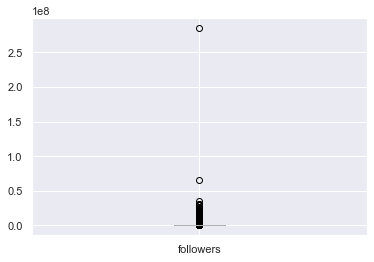

In [70]:
profiles_filtered.boxplot(column=['followers']) #The following boxplot shows the empirical distribution of followers for each user.

In [71]:
fmode = profiles_filtered["followers"].mode()
print("Mode number of followers: "+ str(fmode))
#With the describe() funtion, it is possible to extract in one shot the mean and the percentiles we aree interested in
profiles_filtered["followers"].describe(percentiles = [.25, .75])

Mode number of followers: 0    0.0
dtype: float64


count    3.452771e+06
mean     4.739899e+03
std      1.939087e+05
min      0.000000e+00
25%      1.590000e+02
50%      4.060000e+02
75%      9.740000e+02
max      2.854576e+08
Name: followers, dtype: float64

What are histograms, bar plots, scatterplots and pie charts used for?

- HISTOGRAMS: they show the distribution of the frequency of a single quantitative variable, grouping data inside intervals which are equidistant on  the x-axis and counting the observations per each interval on the y-axis.
- BAR PLOTS: are generally used to compare variables coming from different groups. Normally on the x-axis are reported categorical variables (groups) rather than quantitative ones. On the y-axis it is possible to describe the total frequency (count) of observations for each group, but also the mean. They can be grouped or stacked when it is necessary to describe two different categorical variables.
- SCATTERPLOTS: they require to arrays of quantitative data. Each pair of data form the data points which represent the observations. The major goal of a scatterplot is to highlight the existing relations between the variables and , if possible, to reveal a correlation.
- PIE CHARTS: are often used for the same task as bar plots. They allow to focus more on the weight of each category within the total number of observations.


What insights can you extract from a Box Plot?

Boxplots are used to show the distribution of a variable. They allow to extract immediately 5 values:
- Minimum value
- First quartile (the value that separates the lowest 25% of the values from the others)
- Median
- Third quartile (the value that separates the highest 25% of the values from the others)
- Maximum value
Boxplots are much more efficient in providing viewers with the outliers rather than a histogram